# Get averages of log fold changes of clusters from cytoscape

Also generate heatmaps of clusters

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pandas as pd
import random
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
from matplotlib import cm


from IPython.display import display

print(np.__version__)
print(sns.__version__)
print(nx.__version__)
print(pd.__version__)
import matplotlib
print(matplotlib.__version__)


# latex rendering of text in graphs
import matplotlib as mpl
mpl.rc('text', usetex = False)
mpl.rc('font', family = 'serif')

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

sns.set(font_scale=1.5)

sns.set_style('white')

sns.set_style("ticks", {"xtick.major.size": 15, "ytick.major.size": 15})
plt.rcParams['svg.fonttype'] = 'none'

import sys


1.19.2
0.11.0
2.5
1.1.3
3.3.2


# Load clusters computed from cytoscape CDAPS application

https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1008239

In [2]:
oslom_df = pd.read_csv('oslomOutput/functionally_enriched/oslom_HandL_day247_enr.csv')
oslom_df.index=oslom_df['shared name']
oslom_df = oslom_df.sort_values('CD_MemberList_Size')
oslom_df.head()

,CD_AnnotatedAlgorithm,CD_AnnotatedMembers,CD_AnnotatedMembers_Overlap,CD_AnnotatedMembers_Pvalue,CD_AnnotatedMembers_Size,CD_AnnotatedMembers_SourceDB,CD_AnnotatedMembers_SourceTerm,CD_CommunityName,CD_Labeled,CD_MemberList,CD_MemberList_LogSize,CD_MemberList_Size,CD_NonAnnotatedMembers,name,selected,shared name
shared name,,,,,,,,,,,,,,,,
C283651,Annotated by gProfiler [Docker: coleslawndex/c...,PSMB10,0.167,4.251740e-02,1,GO:CC,GO:1990111,spermatoproteasome complex,True,LIMD1 PSMB10 PSMD9,1.585,3,LIMD1 PSMD9,C283651,False,C283651
C283649,Annotated by gProfiler [Docker: coleslawndex/c...,TBCC TUBA1B TUBA8,0.130,9.619396e-09,3,REAC,REAC:R-HSA-389977,Post-chaperonin tubulin folding pathway,True,TBCC TUBA1B TUBA8,1.585,3,NaN,C283649,False,C283649
C283650,Annotated by gProfiler [Docker: coleslawndex/c...,PKN1,0.200,9.998113e-02,1,GO:MF,GO:0035402,histone kinase activity (H3-T11 specific),True,GNA13 OBSCN PKN1 RHOC,2.000,4,GNA13 OBSCN RHOC,C283650,False,C283650
C283652,Annotated by gProfiler [Docker: coleslawndex/c...,JUNB JUND,0.333,4.948241e-06,2,GO:CC,GO:0035976,transcription factor AP-1 complex,True,CREB5 JUNB JUND MLLT6,2.000,4,CREB5 MLLT6,C283652,False,C283652
C283655,Annotated by gProfiler [Docker: coleslawndex/c...,E2F1,0.167,3.325958e-02,1,GO:CC,GO:0035189,Rb-E2F complex,True,CCND2 CDK3 CDKN1C E2F1 MYBL2,2.322,5,CCND2 CDK3 CDKN1C MYBL2,C283655,False,C283655


# Load the node data

In [3]:
node_df = pd.read_csv('nodeLists/DE_nodeList_HandL_union_days247_210324.txt',sep='\t',index_col='name_H')

node_df.head()

,baseMean_d2_H,log2FoldChange_d2_H,lfcSE_d2_H,stat_d2_H,pvalue_d2_H,padj_d2_H,baseMean_d4_H,log2FoldChange_d4_H,lfcSE_d4_H,stat_d4_H,...,stat_d7_L,pvalue_d7_L,padj_d7_L,baseMean_d92_L,log2FoldChange_d92_L,lfcSE_d92_L,stat_d92_L,pvalue_d92_L,padj_d92_L,name_L
name_H,,,,,,,,,,,,,,,,,,,,,
ACADS,32.485738,1.059808,0.334238,3.170818,0.001520,0.041343,24.854684,0.111315,0.374799,0.296999,...,-0.685907,0.492772,0.962064,39.858673,1.347466,0.442333,3.046268,0.002317,0.034132,ACADS
ACKR1,28.437747,0.633850,0.509218,1.244752,0.213223,0.442395,22.170349,-0.031476,0.558833,-0.056324,...,-0.421344,0.673504,0.978163,17.311646,0.408616,0.541143,0.755098,0.450190,0.716813,ACKR1
ACO1,2323.062069,0.215760,0.202158,1.067287,0.285842,0.519561,2499.560381,0.317255,0.272578,1.163905,...,1.640803,0.100838,0.805439,2534.770320,-0.412686,0.212102,-1.945692,0.051692,0.232440,ACO1
ACSBG1,170.483463,-0.218550,0.491507,-0.444652,0.656571,0.818201,215.903907,0.477345,0.454330,1.050658,...,3.042289,0.002348,0.231712,141.770212,0.866596,0.389720,2.223638,0.026173,0.158715,ACSBG1
ADCK1,57.789526,1.074000,0.317721,3.380322,0.000724,0.030944,45.175009,0.438262,0.306667,1.429116,...,0.230734,0.817522,0.987271,50.062716,0.467467,0.361243,1.294051,0.195648,0.481672,ADCK1


In [4]:
# make and save heatmaps for genes in each cluster

logFC_cols = [c for c in node_df.columns.tolist() if c.startswith('log2FoldChange')]

node_FC_df = node_df[logFC_cols]
node_FC_df.head()

,log2FoldChange_d2_H,log2FoldChange_d4_H,log2FoldChange_d7_H,log2FoldChange_d92_H,log2FoldChange_d2_L,log2FoldChange_d4_L,log2FoldChange_d7_L,log2FoldChange_d92_L
name_H,,,,,,,,
ACADS,1.059808,0.111315,0.255696,2.161153,0.725788,-0.076664,-0.420765,1.347466
ACKR1,0.633850,-0.031476,-0.379882,0.409475,1.239709,0.766018,-0.214307,0.408616
ACO1,0.215760,0.317255,1.199512,-0.202439,-0.493170,0.298807,0.475377,-0.412686
ACSBG1,-0.218550,0.477345,0.341309,-0.718475,1.504734,0.757798,1.670480,0.866596
ADCK1,1.074000,0.438262,0.620066,0.736179,0.695326,0.374215,0.078690,0.467467


In [9]:
len(oslom_df)
from matplotlib import cm
import scipy.spatial as sp, scipy.cluster.hierarchy as hc

C283651
C283649


<ipython-input-10-ae6744fb4942>:17: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("bwr"))
  cmap1.set_bad("#D8DCD6")
/opt/anaconda3/lib/python3.8/site-packages/seaborn/matrix.py:1204: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout(**tight_params)


C283650
C283652
C283655
C283657
C283661
C283656
C283654
C283660
C283659
C283658
C283653
C283692
C283727


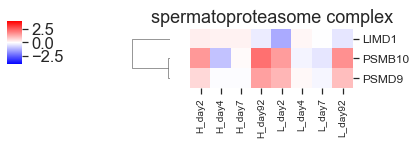

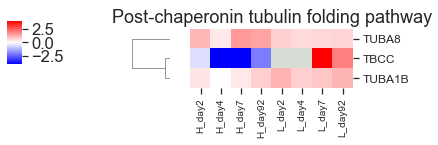

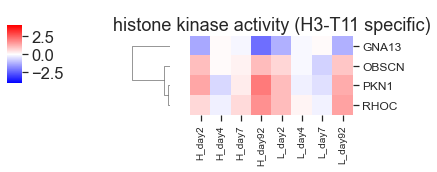

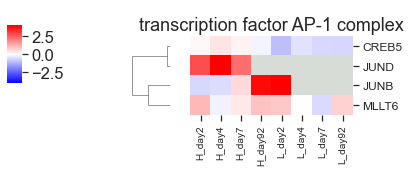

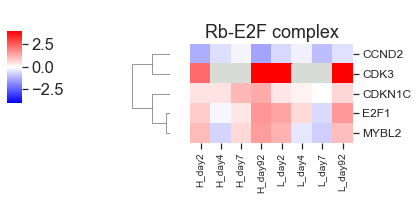

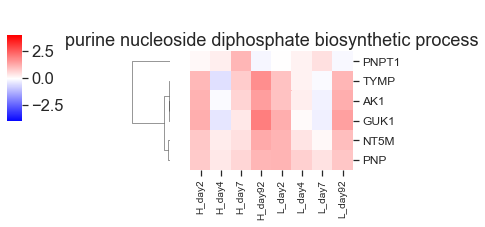

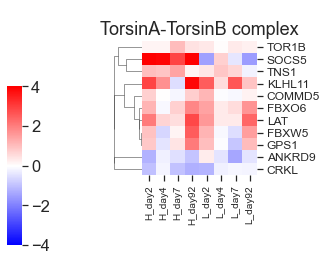

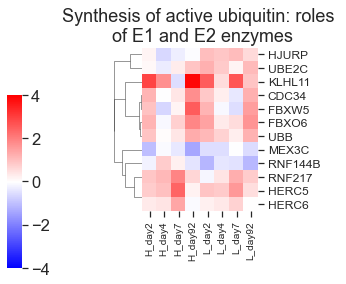

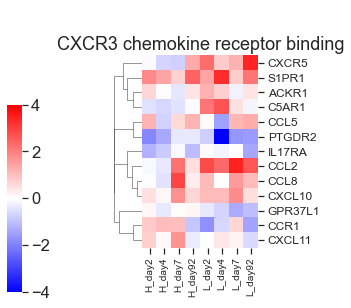

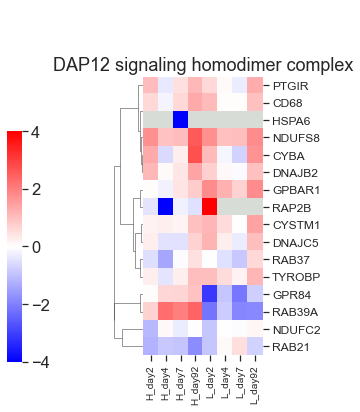

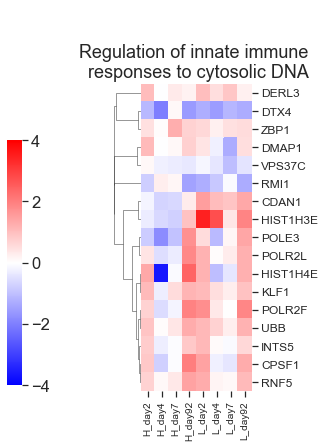

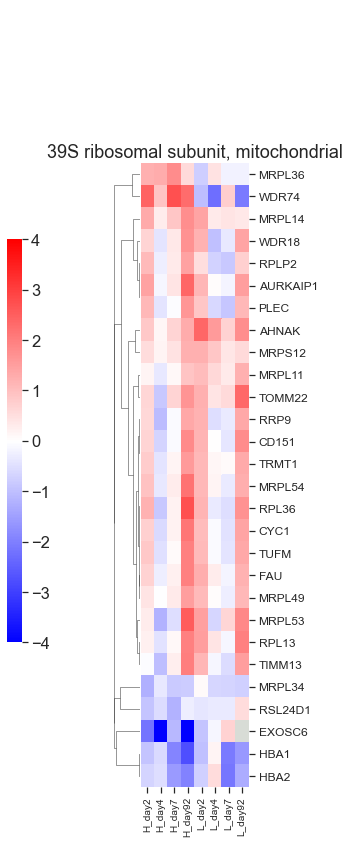

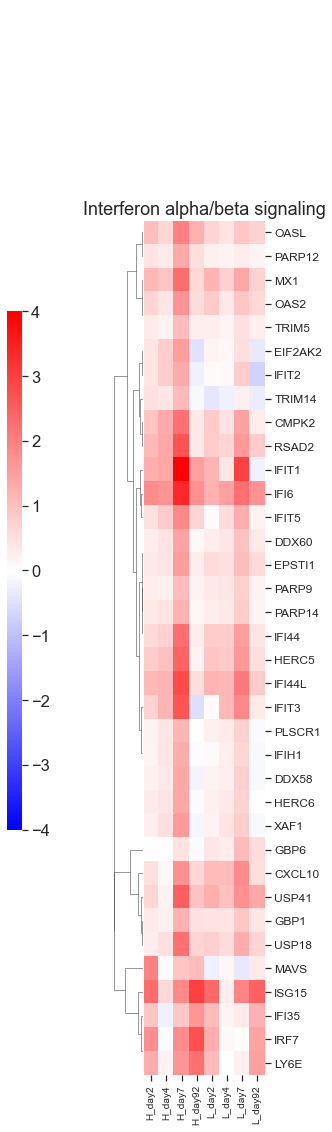

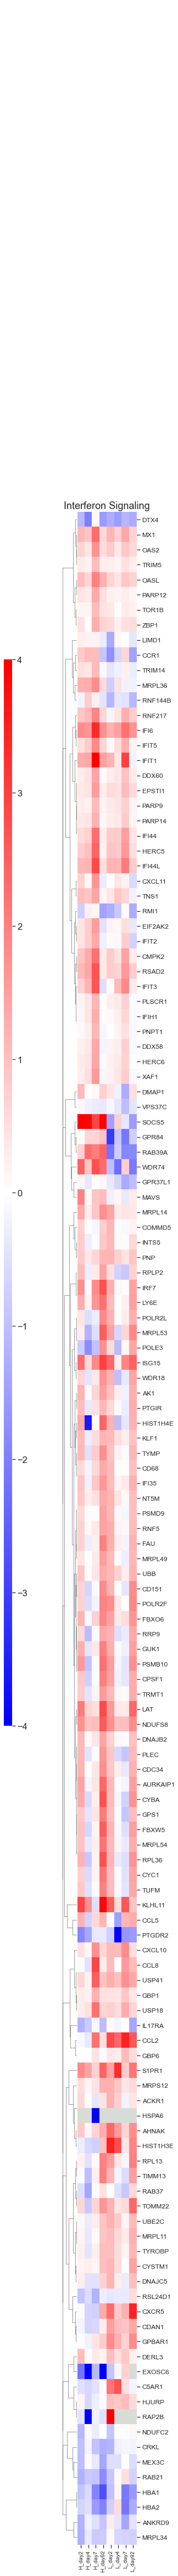

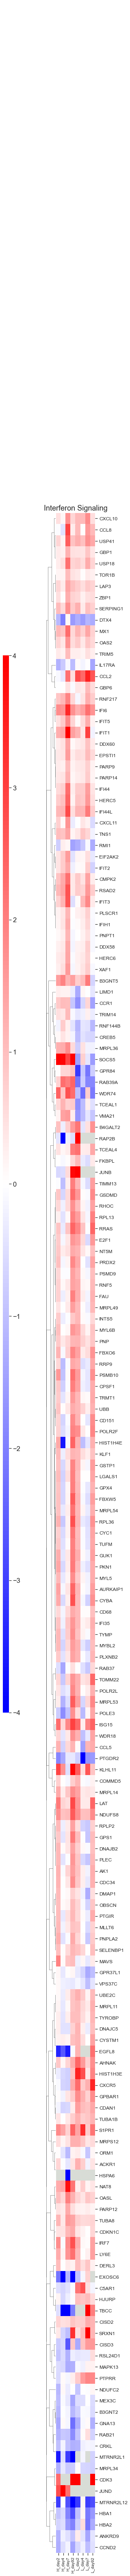

In [10]:
# loop over each cluster of interest, plot and save heatmap
for clust in oslom_df['shared name']:
    focal_cluster = clust
    print(clust)

    focal_genes = oslom_df.loc[focal_cluster]['CD_MemberList'].split(' ')
    focal_genes = [gene.upper() for gene in focal_genes]
    subs = node_FC_df.loc[focal_genes]
    
    #print(subs[subs.isna().any(axis=1)])
    #print(len(focal_genes))
    
    row_dism = 1 - node_FC_df.loc[focal_genes].T.corr()
    row_dism = row_dism.fillna(0)
    row_dism = np.clip(row_dism,0,1)
    cmap1 = cm.get_cmap("bwr")
    cmap1.set_bad("#D8DCD6")
    row_linkage = hc.linkage(sp.distance.squareform(row_dism), method='complete')
    
    cfig = sns.clustermap(node_FC_df.loc[focal_genes],vmin=-4,vmax=4,col_cluster=False,
                         figsize=(4,0.5*len(focal_genes)),yticklabels=1,
                         row_linkage=row_linkage,cmap=cmap1)
    #print(focal_genes)
    #print(node_FC_df.loc[focal_genes])
    
    ax_cbar = plt.gca()
    
    # move colorbar
    ax_cbar.set_position((-.3, .35, .05, .4))
    # plt.ylabel('log2FC from baseline')

    plt.sca(cfig.ax_heatmap)
    plt.ylabel('')
    plt.yticks(rotation='horizontal',fontsize=12)
    tmp=plt.xticks(np.arange(8)+.5,['H_day2','H_day4','H_day7','H_day92','L_day2','L_day4','L_day7','L_day92'],fontsize=10)
    name = oslom_df.loc[focal_cluster]['CD_CommunityName']
    if len(name) > 50:
        nameList = name.split()
        if len(nameList) % 2 == 0:
            n= len(nameList)
            newName = ' '.join(nameList[0:int(n/2)]) + ' \n ' + ' '.join(nameList[int(n/2):int(n)])
            plt.title(newName)
        elif len(nameList) % 2 != 0:
            n= len(nameList)+1
            newName = ' '.join(nameList[0:int(n/2)]) + ' \n ' + ' '.join(nameList[int(n/2):int(n-1)])
            plt.title(newName)
    else:
        plt.title(name)

    #plt.savefig('Figures/heatmaps/HandL_day2/'+focal_cluster+'.png',dpi=300,bbox_inches='tight')

# measure the average log FC of genes per cluster

In [15]:
avg_LFC_day2_H,avg_LFC_day4_H,avg_LFC_day6_H,avg_LFC_day8_H=[],[],[],[]
frac_up_day2_H,frac_up_day4_H,frac_up_day6_H,frac_up_day8_H=[],[],[],[]

avg_LFC_day2_L,avg_LFC_day4_L,avg_LFC_day6_L,avg_LFC_day8_L=[],[],[],[]
frac_up_day2_L,frac_up_day4_L,frac_up_day6_L,frac_up_day8_L=[],[],[],[]

for c in oslom_df.index.tolist():

    focal_genes = oslom_df.loc[c]['CD_MemberList'].split(' ')
    
    
    avg_LFC_day2_H.append(node_df['log2FoldChange_d2_H'].loc[focal_genes].mean())
    avg_LFC_day4_H.append(node_df['log2FoldChange_d4_H'].loc[focal_genes].mean())
    avg_LFC_day6_H.append(node_df['log2FoldChange_d7_H'].loc[focal_genes].mean())
    avg_LFC_day8_H.append(node_df['log2FoldChange_d92_H'].loc[focal_genes].mean())
    
    avg_LFC_day2_L.append(node_df['log2FoldChange_d2_L'].loc[focal_genes].mean())
    avg_LFC_day4_L.append(node_df['log2FoldChange_d4_L'].loc[focal_genes].mean())
    avg_LFC_day6_L.append(node_df['log2FoldChange_d7_L'].loc[focal_genes].mean())
    avg_LFC_day8_L.append(node_df['log2FoldChange_d92_L'].loc[focal_genes].mean())
    
    frac_up_day2_H.append(1.0*sum(node_df['log2FoldChange_d2_H'].loc[focal_genes]>0)/len(focal_genes))
    frac_up_day4_H.append(1.0*sum(node_df['log2FoldChange_d4_H'].loc[focal_genes]>0)/len(focal_genes))
    frac_up_day6_H.append(1.0*sum(node_df['log2FoldChange_d7_H'].loc[focal_genes]>0)/len(focal_genes))
    frac_up_day8_H.append(1.0*sum(node_df['log2FoldChange_d92_H'].loc[focal_genes]>0)/len(focal_genes))
    
    frac_up_day2_L.append(1.0*sum(node_df['log2FoldChange_d2_L'].loc[focal_genes]>0)/len(focal_genes))
    frac_up_day4_L.append(1.0*sum(node_df['log2FoldChange_d4_L'].loc[focal_genes]>0)/len(focal_genes))
    frac_up_day6_L.append(1.0*sum(node_df['log2FoldChange_d7_L'].loc[focal_genes]>0)/len(focal_genes))
    frac_up_day8_L.append(1.0*sum(node_df['log2FoldChange_d92_L'].loc[focal_genes]>0)/len(focal_genes))
    
    
oslom_df['avg_LFC_d2_H']=avg_LFC_day2_H
oslom_df['avg_LFC_d4_H']=avg_LFC_day4_H
oslom_df['avg_LFC_d7_H']=avg_LFC_day6_H
oslom_df['avg_LFC_d92_H']=avg_LFC_day8_H

oslom_df['avg_LFC_d2_L']=avg_LFC_day2_L
oslom_df['avg_LFC_d4_L']=avg_LFC_day4_L
oslom_df['avg_LFC_d7_L']=avg_LFC_day6_L
oslom_df['avg_LFC_d92_L']=avg_LFC_day8_L

oslom_df['frac_up_d2_H']=frac_up_day2_H
oslom_df['frac_up_d4_H']=frac_up_day4_H
oslom_df['frac_up_d7_H']=frac_up_day6_H
oslom_df['frac_up_d92_H']=frac_up_day8_H

oslom_df['frac_up_d2_L']=frac_up_day2_L
oslom_df['frac_up_d4_L']=frac_up_day4_L
oslom_df['frac_up_d7_L']=frac_up_day6_L
oslom_df['frac_up_d92_L']=frac_up_day8_L

oslom_df

,CD_AnnotatedAlgorithm,CD_AnnotatedMembers,CD_AnnotatedMembers_Overlap,CD_AnnotatedMembers_Pvalue,CD_AnnotatedMembers_Size,CD_AnnotatedMembers_SourceDB,CD_AnnotatedMembers_SourceTerm,CD_CommunityName,CD_Labeled,CD_MemberList,...,avg_LFC_d7_L,avg_LFC_d92_L,frac_up_d2_H,frac_up_d4_H,frac_up_d7_H,frac_up_d92_H,frac_up_d2_L,frac_up_d4_L,frac_up_d7_L,frac_up_d92_L
shared name,,,,,,,,,,,,,,,,,,,,,
C283649,Annotated by gProfiler [Docker: coleslawndex/c...,TBCC TUBA1B TUBA8,0.130,9.619396e-09,3,REAC,REAC:R-HSA-389977,Post-chaperonin tubulin folding pathway,True,TBCC TUBA1B TUBA8,...,2.272015,1.284286,0.666667,0.333333,0.666667,0.666667,0.666667,0.666667,1.000000,1.000000
C283650,Annotated by gProfiler [Docker: coleslawndex/c...,PKN1,0.200,9.998113e-02,1,GO:MF,GO:0035402,histone kinase activity (H3-T11 specific),True,GNA13 OBSCN PKN1 RHOC,...,-0.326460,0.597512,0.750000,0.500000,0.750000,0.750000,0.750000,0.250000,0.250000,0.750000
C283651,Annotated by gProfiler [Docker: coleslawndex/c...,PSMB10,0.167,4.251740e-02,1,GO:CC,GO:1990111,spermatoproteasome complex,True,LIMD1 PSMB10 PSMD9,...,-0.172496,0.788388,1.000000,0.333333,0.666667,0.666667,0.666667,0.666667,0.000000,0.666667
C283652,Annotated by gProfiler [Docker: coleslawndex/c...,JUNB JUND,0.333,4.948241e-06,2,GO:CC,GO:0035976,transcription factor AP-1 complex,True,CREB5 JUNB JUND MLLT6,...,-0.589024,0.040201,0.750000,0.500000,1.000000,0.500000,0.500000,0.000000,0.000000,0.250000
C283653,Annotated by gProfiler [Docker: coleslawndex/c...,IFI35 IFI6 IFIT1 IFIT2 IFIT3 IRF7 ISG15 MX1 OA...,0.148,3.445604e-28,13,REAC,REAC:R-HSA-909733,Interferon alpha/beta signaling,True,CMPK2 CXCL10 DDX58 DDX60 EIF2AK2 EPSTI1 GBP1 G...,...,1.061654,0.479126,0.972222,0.944444,1.000000,0.722222,0.944444,0.972222,0.972222,0.777778
C283654,Annotated by gProfiler [Docker: coleslawndex/c...,CXCL10 CXCL11,0.125,9.870317e-05,2,GO:MF,GO:0048248,CXCR3 chemokine receptor binding,True,ACKR1 C5AR1 CCL2 CCL5 CCL8 CCR1 CXCL10 CXCL11 ...,...,0.630017,0.411174,0.538462,0.307692,0.615385,0.615385,0.692308,0.615385,0.769231,0.538462
C283655,Annotated by gProfiler [Docker: coleslawndex/c...,E2F1,0.167,3.325958e-02,1,GO:CC,GO:0035189,Rb-E2F complex,True,CCND2 CDK3 CDKN1C E2F1 MYBL2,...,-0.581091,1.416222,0.800000,0.200000,0.600000,0.800000,0.800000,0.400000,0.200000,0.800000
C283656,Annotated by gProfiler [Docker: coleslawndex/c...,CDC34 UBB UBE2C,0.077,6.058407e-06,3,REAC,REAC:R-HSA-8866652,Synthesis of active ubiquitin: roles of E1 and...,True,CDC34 FBXO6 FBXW5 HERC5 HERC6 HJURP KLHL11 MEX...,...,0.578404,0.656464,0.833333,0.500000,0.750000,0.666667,0.750000,0.750000,0.666667,0.833333
C283657,Annotated by gProfiler [Docker: coleslawndex/c...,AK1 GUK1,0.200,6.655043e-05,2,GO:BP,GO:0009136,purine nucleoside diphosphate biosynthetic pro...,True,AK1 GUK1 NT5M PNP PNPT1 TYMP,...,0.091137,0.941376,1.000000,0.500000,1.000000,0.833333,1.000000,1.000000,0.500000,0.833333


In [16]:
oslom_df.to_csv('oslomAnnotated/oslom_DenV_compare_HandL_day247_annotated_210324.txt',sep='\t')